# HLESolver Example

> Usage demo of `qom.solvers.HLESolver` module.

## Imports

In [1]:
# dependencies
import numpy as np

# qom modules
from qom.solvers import HLESolver
from qom.ui.plotters import MPLPlotter

## Basic Usage

### Modes and Correlations

The rate equations of the mode amplitudes and correlations can be clubbed into a single form starting with the modes and then the correlations.
Here, we demonstrate it with a simple optomechanical system consisting of a single optical and a single mechanical mode initialized in its ground state.

In [2]:
# format of the ODE function containing the rates
# the first argument is the time at which the rates are calculated
# the second argument contains a list of values for the modes and correlations
def ode_func(t, v):
    # extract the classical amplitues of the optical and mechanical modes
    alpha = v[0]
    beta = v[1]
    # extract the quantum correlations between the quadratures of the modes
    corrs = np.real(v[2:]).reshape(4, 4)

    # frequently used variables
    omega_m = 1
    Delta_0 = omega_m
    kappa = 7.5e-1 * omega_m
    gamma = 1e-5 * omega_m
    G_0 = 3.5e-5 * omega_m
    E = 6.4e3 * omega_m
    n_th = 0

    # effective frequencies
    Delta = Delta_0 - G_0 * np.real(beta)
    G = np.sqrt(2) * G_0 * alpha

    # optical mode rate
    dalpha_dt = - (kappa + 1j * Delta) * alpha + E
    # mechanical mode rate
    dbeta_dt = 1j * G / 2 * np.conjugate(alpha) - (gamma + 1j * omega_m) * beta

    # drift matrix
    A = np.zeros([4, 4], dtype=np.float_)
    A[0][0] = - kappa
    A[0][1] = Delta
    A[0][2] = - np.imag(G)
    A[1][0] = - Delta
    A[1][1] = - kappa
    A[1][2] = np.real(G)
    A[2][2] = - gamma
    A[2][3] = omega_m
    A[3][0] = np.real(G)
    A[3][1] = np.imag(G)
    A[3][2] = - omega_m
    A[3][3] = - gamma

    # noise matrix
    D = np.zeros([4, 4], dtype=np.float_)
    D[0][0] = kappa
    D[1][1] = kappa
    D[2][2] = gamma * (2 * n_th + 1)
    D[3][3] = gamma * (2 * n_th + 1)

    # correlation rate
    dcorrs_dt = A.dot(corrs) + corrs.dot(A.transpose()) + D

    # mirror matrix about diagonal 
    for i in range(len(dcorrs_dt)):
        for j in range(0, i):
            dcorrs_dt[i, j] = dcorrs_dt[j, i]
        
    # convert to list and concatenate all rates
    rates = [dalpha_dt, dbeta_dt] + [np.complex(ele) for ele in dcorrs_dt.flatten()]

    return rates

# initial values
# the modes are initialized to zero
modes_0 = np.zeros(2, dtype=np.complex_).tolist()
# the correlations are initialized to their ground state thermal occupancies
corrs_0 = np.zeros([4, 4], dtype=np.float_)
corrs_0[0][0] = 1 / 2
corrs_0[1][1] = 1 / 2
corrs_0[2][2] = 1 / 2
corrs_0[3][3] = 1 / 2
# concatenate all initialvalues
iv = modes_0 + [np.complex_(ele) for ele in corrs_0.flatten()]

### Obtaining and Plotting Results

The `solve` method calculates the results stored with keys `T` and `V`.
The `get_Modes` and `get_Corrs` methods can be used to extract the corresponding modes and correlations from the calculated results. 
Here, we plot the dynamics of the optical mode.

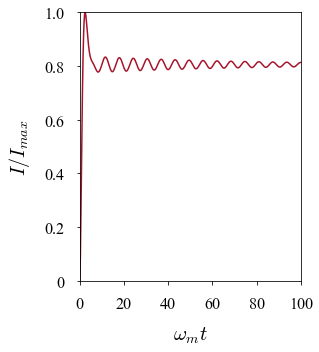

In [3]:
# all parameters
params = {
    'solver': {
        'show_progress': True,
        'method': 'ode',
        't_min': 0,
        't_max': 100,
        't_dim': 1001
    },
    'plotter': {
        'type': 'line',
        'x_label': '$\\omega_m t$',
        'x_bound': 'both',
        'x_ticks': [0, 20, 40, 60, 80, 100],
        'v_label': '$I / I_{max}$',
        'v_bound': 'both',
        'v_ticks': [0, 0.2, 0.4, 0.6, 0.8, 1.0]

    }
}

# initialize the solver with the parameters
solver = HLESolver(params['solver'])
# obtain the results of the integration
results = solver.solve(ode_func, iv, cache=False)
# extract the optical mode intensities
I = [np.conjugate(ele[0]) * ele[0] for ele in solver.get_Modes()]
# normalize the intensities
I_max = np.max(np.real(I))
I_norm = [np.real(ele) / I_max for ele in I]

# initialize the plotter with the axis values and the parameters
plotter = MPLPlotter({'X': results['T']}, params['plotter'])
# update the plotter with the intensities
plotter.update(xs=results['T'], vs=I_norm)
# display the plot
plotter.show(True)